In [1]:
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
import numpy as np
from datetime import datetime

### Loading the dust case:

In [2]:
df = pd.read_csv('Dust_LatLon_Drobo_Complete_June2022_Jesse - Data LatLon.csv')
df_case = df[df["Date (YYYYMMDD)"] == 20140427.0]

### Visualizing the cross-section area: 

In [3]:
u_ds = xr.open_dataset('uwnd.201404.nc')
v_ds = xr.open_dataset('vwnd.201404.nc')
temp_ds = xr.open_dataset('air.201404.nc')

/home/jturner/miniconda3/lib/python3.9/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jturner/miniconda3/lib/python3.9/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/jturner/miniconda3/lib/python3.9/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [4]:
level = 1000  #hPa
dt = datetime(2014, 4, 27, 15, 0, 0, 0) 
x=slice(5900000, 6000000)
y=slice(2000000, 3500000)

u_ds_sel = u_ds.sel(level=level, time=dt, x=x, y=y)

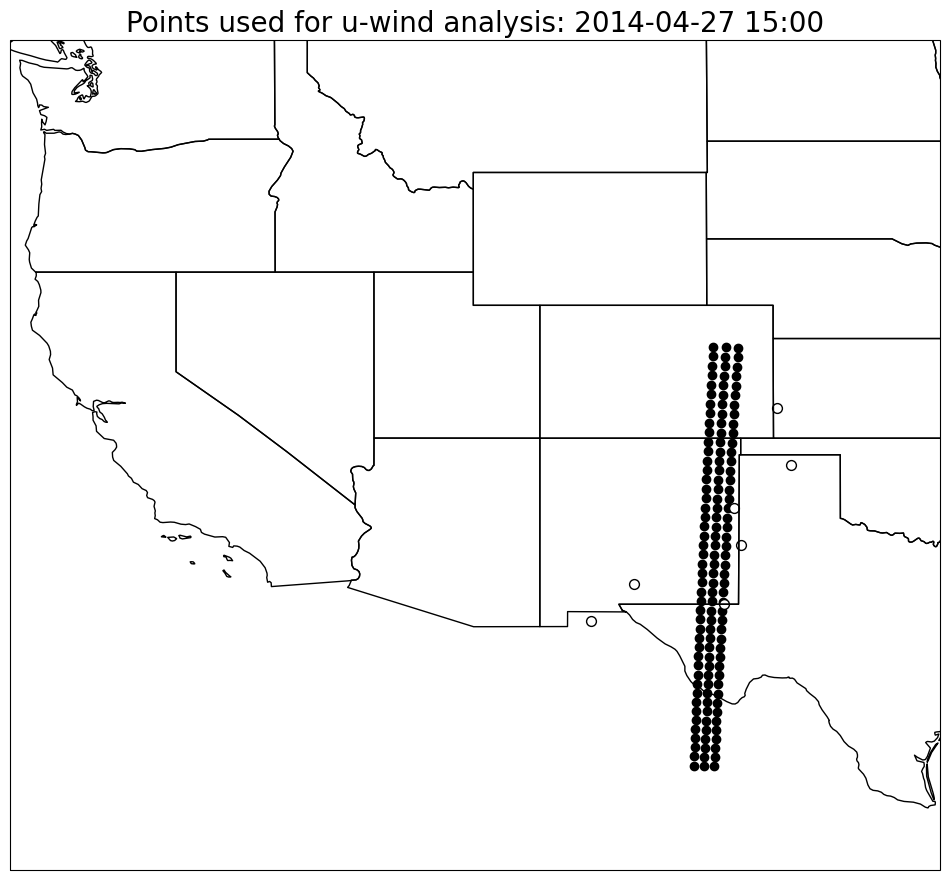

In [5]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.jet

ax.set_extent([-125, -97, 24, 49], crs=ccrs.PlateCarree())

sel=ax.scatter(u_ds_sel.lon, u_ds_sel.lat, c='black')

dust=ax.scatter(df_case.longitude, df_case.latitude, c='white', edgecolors='black', s=50)

formatted_dt = dt.strftime('%Y-%m-%d %H:%M')
ax.set_title('Points used for u-wind analysis: '+formatted_dt, size=20)
ax.add_feature(cfeature.STATES)

### Making the cross-section analysis for u-wind:

In [6]:
dt = datetime(2014, 4, 27, 15, 0, 0, 0) 
x=5908266.0
y=slice(2000000, 3500000)

u_ds_sel = u_ds.sel(time=dt, x=x, y=y)
v_ds_sel = v_ds.sel(time=dt, x=x, y=y)
temp_ds_sel = temp_ds.sel(time=dt, x=x, y=y)

#u_ds_sel = u_ds_sel.mean(dim='x')

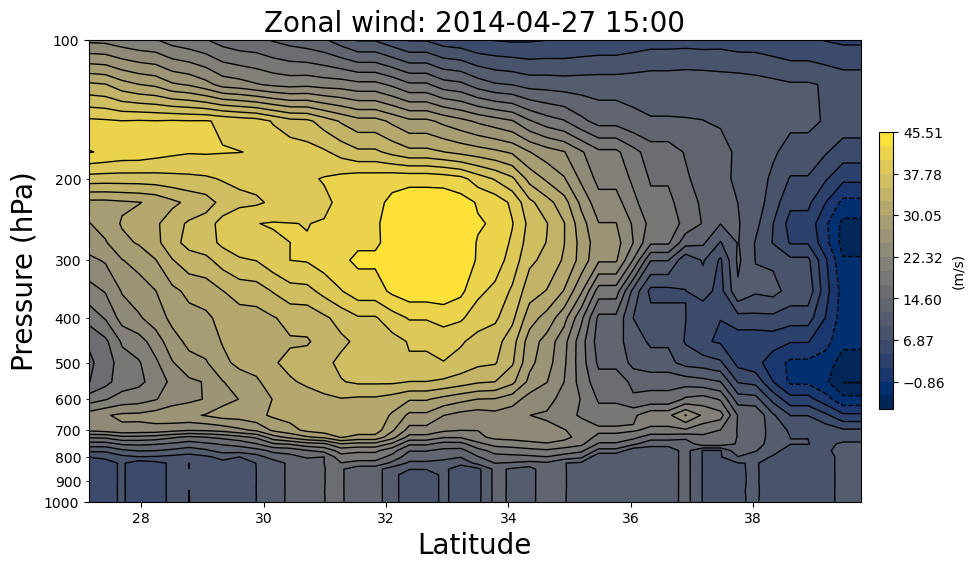

In [7]:
fig,ax=plt.subplots(1, figsize=(12,6))
ax.set_yscale('log')
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

cmap = plt.cm.cividis
levels = np.linspace(np.min(u_ds_sel.uwnd), np.max(u_ds_sel.uwnd), 21)

#--- Original black contours with labels
#u=ax.contour(u_ds_sel.lat, u_ds_sel.level, u_ds_sel.uwnd, levels=levels, colors='black')
#cl=plt.clabel(u, inline=True, fmt='%1i', fontsize=12)

u=ax.contourf(u_ds_sel.lat, u_ds_sel.level, u_ds_sel.uwnd, levels=levels, cmap=cmap, extend='neither')
uc=ax.contour(u_ds_sel.lat, u_ds_sel.level, u_ds_sel.uwnd, levels=levels, colors='black', linewidths=1)
clb=plt.colorbar(u, shrink=0.6, pad=0.02, ax=ax)
clb.set_label('(m/s)')

formatted_dt = dt.strftime('%Y-%m-%d %H:%M')
ax.set_title('Zonal wind: '+formatted_dt, size=20)
ax.set_xlabel('Latitude', size=20)
ax.set_ylabel('Pressure (hPa)', size=20)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.savefig('zonal_wind.png', dpi=200, bbox_inches='tight')

### Calculating the potential temperature

$$
\theta = T\left(\frac{1000}{P}\right)^{\frac{R_d}{C_p}}
$$

In [8]:
temp_ds_sel.level

PT = temp_ds_sel.air * (1000/temp_ds_sel.air.level)**.286

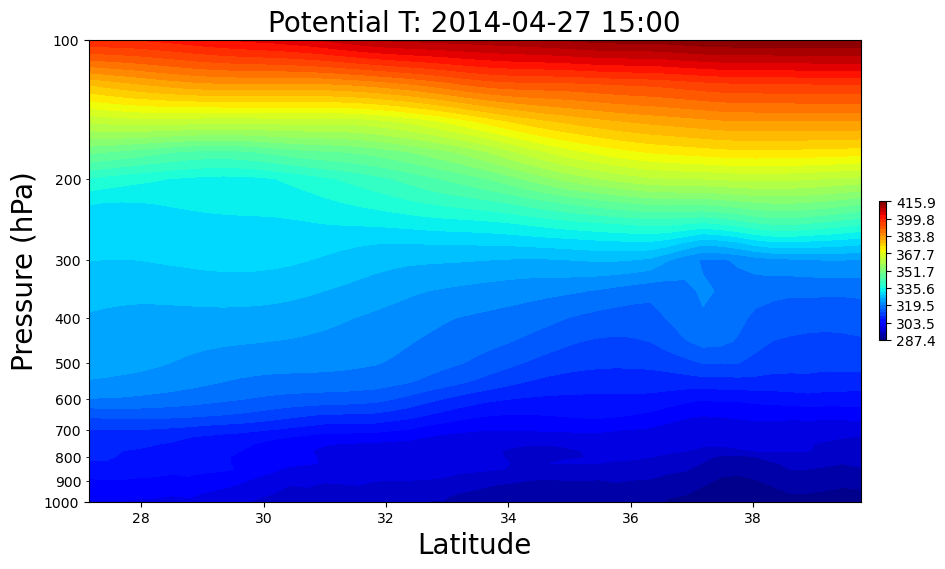

In [9]:
fig,ax=plt.subplots(1, figsize=(12,6))
ax.set_yscale('log')
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
cmap = plt.cm.jet
levels = np.linspace(np.min(PT), np.max(PT), 41)

pt=ax.contourf(u_ds_sel.lat, u_ds_sel.level, PT, cmap=cmap, levels=levels)
clb=plt.colorbar(pt, shrink=0.3, pad=0.02, ax=ax)

formatted_dt = dt.strftime('%Y-%m-%d %H:%M')
ax.set_title('Potential T: '+formatted_dt, size=20)
ax.set_xlabel('Latitude', size=20)
ax.set_ylabel('Pressure (hPa)', size=20)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))